# FINANCIAL ENGINEERING PROJECT
# Topic: Long Straddle
## Members: Thi Hong Nhung Phan & Hoang Phi Long Dang

In [65]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


# 1. Import data from Yahoofinance

## 1.1. One-year data

In [66]:
ticket = "AAPL"  # Apple Inc. - highly liquid options market
print(f"Selected ticker: {ticket}")
print("Apple Inc. has one of the most liquid option markets globally")

Selected ticker: AAPL
Apple Inc. has one of the most liquid option markets globally


### Ticker Selection for Option Data Availability

We're choosing AAPL (Apple Inc.) for the option strategy analysis because:

1. **Option Market Liquidity**: AAPL has one of the most liquid option markets globally with tight bid-ask spreads
2. **Data Availability**: Real-time option data is readily available through yfinance for US-listed securities
3. **Market Depth**: Multiple expiration dates and strike prices are actively traded
4. **Analysis Quality**: Real market data provides more accurate insights than simulated premiums

For the option strategy implementation, we'll use this Ticket to access real market data and compare actual vs. theoretical pricing.

In [67]:
ticket = "AAPL"

# Download AAPL data for 1 year (more relevant for options volatility)
data_1y = yf.download(ticket, 
                     start=(pd.Timestamp.now() - pd.DateOffset(years=1)).date(),
                     end=pd.Timestamp.now().date(),
                     progress=False)  # Disable progress bar

# Flatten MultiIndex columns if present
if isinstance(data_1y.columns, pd.MultiIndex):
    data_1y.columns = [col[0] for col in data_1y.columns]

# Calculate daily returns
data_1y['daily_return'] = np.log(data_1y["Close"]/data_1y["Close"].shift(1))

C:\Users\admin\AppData\Local\Temp\ipykernel_15272\2110521910.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_1y = yf.download(ticket,


## 1.2. Two-year data

In [68]:
# Download 2-year data for volatility comparison
data_2y = yf.download(ticket, 
                     start=(pd.Timestamp.now() - pd.DateOffset(years=2)).date(),
                     end=pd.Timestamp.now().date(),
                     progress=False)

# Flatten MultiIndex columns if present
if isinstance(data_2y.columns, pd.MultiIndex):
    data_2y.columns = [col[0] for col in data_2y.columns]

data_2y['daily_return'] = np.log(data_2y["Close"]/data_2y["Close"].shift(1))

C:\Users\admin\AppData\Local\Temp\ipykernel_15272\1762746664.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_2y = yf.download(ticket,


## 1.3. Ten-year data

In [69]:
# Download 10-year data for long-term volatility
data_10y = yf.download(ticket, 
                      start=(pd.Timestamp.now() - pd.DateOffset(years=10)).date(),
                      end=pd.Timestamp.now().date(),
                      progress=False)

# Flatten MultiIndex columns if present
if isinstance(data_10y.columns, pd.MultiIndex):
    data_10y.columns = [col[0] for col in data_10y.columns]

data_10y['daily_return'] = np.log(data_10y["Close"]/data_10y["Close"].shift(1))

C:\Users\admin\AppData\Local\Temp\ipykernel_15272\2547160140.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_10y = yf.download(ticket,


# 2. Analyzing whether time-series of underlying (stock) follow geometric Brownian Motion (gBM)
According to Henze (2024), a standard Wiener process (Brownian motion) is a stochastic process $\{W_t\}_{t \geq 0}$ indexed by nonnegative real numbers $t$ with the following properties:

1. $\ W_0 = 0$

2. The increment $( W_{t+s} - W_s )$ has the ${Normal}(0, t)$ distribution.

3. The process $ \{W_t\}_{t \geq 0} $ has stationary, independent increments.

3. With probability 1, the function $t \mapsto W_t$ is continuous in $t$


Therefore, in the following sections we will conduct statistical tests for each of these properties. If our time-series data meets all of these properties, then we can state that it follows gBM

# 2.1. Methodology
## 2.1.1. Normality test
For the second property, it is essential to check whether the following data follows a normal distribution. In addition to Statistical test, we also apply the graphical method to compare with the formal statistical test.
### a) Statistical Tests
There are 3 common statistical tests for normality including Kolmogorov-Smirnov Test, Shapiro-Wilk Test and Anderson-Darling Test. However, in the context of this project we apply Shapiro-Wilk Test which is best for small and medium-size dataset (Shapiro & Wilk, 1965).

In this case, we have hypothesis as below:

> $H_0$: The data is normally distributed<br>
> $H_a$: The data is not normally distributed

If p-value < 0.05, the null hypothesis is rejected

### b) Graphical Methods
Beside the abovedmentioned statiscal test, the Quantile-Quantile (Q-Q) plot is used for visually comparing the quantiles of our sample data to the quantiles of a normal distribution. If the data is normally distributed, the points on the Q-Q plot will lie along a straight diagonal line.
## 2.1.2. Test for Independent increments
In the third property, Ljung-Box test is widely used for drawing conclusions on the autocorrelations in the log returns (Mahan et al., 2015). Under gBM, there should be no autocorrelation in the returns.

> $H_0$: The data are independently distributed (no autocorrelation)<br>
> $H_a$: The data are not independently distributed

If p-value < 0.05, the null hypothesis is rejected

## 2.1.3. Test for stationarity
For the third property, the Augmented Dickey-Fuller (ADF) Test is applied for detecting stationary of the first order differentiate of the time series (Steland, 2007). 

> $H_0$: The time series has a unit root (non-stationary)<br>
> $H_a$: The time series is stationary

If p-value < 0.05, the null hypothesis is rejected

## 2.1.4. Continuity test
Geometric Brownian motion is characterized by the following stochastic differential equation:
$$\begin{equation}  dS_t = \mu S_t dt + \sigma S_t dW_t \end{equation}$$

Where:

$S_t$ represents the stock price at time $t$.<br>
$ \mu $ is the drift parameter (average rate of return).<br>
$ \sigma $ is the volatility parameter (measure of price fluctuation).<br>
$ dW_t $ is the increment of a standard Brownian motion, which is a continuous random process.

Brownian motion $S_t$ is said to be continuous if for any small time interval $dt$, the change in the Brownian motion $dW_t$ is a continuous random variable.

Accordingly, we analyze continuity is by looking at the logarithmic returns

# 2.2. Testing results and discussion

## 2.2.1. Testing whether the log process starts at $\ln S_0$

In [70]:
# Define the return variables from existing data
one_year_returns = data_1y['daily_return'].dropna()
two_year_returns = data_2y['daily_return'].dropna()  
ten_year_returns = data_10y['daily_return'].dropna()

# 1-year log return
one_year_returns['cum_log_return'] = one_year_returns.cumsum()
W_t = one_year_returns['cum_log_return'] - one_year_returns['cum_log_return'].iloc[0]
print(f'1-year W_0 = {W_t.iloc[0]:.6f}')

# 2-year log return
two_year_returns['cum_log_return'] = two_year_returns.cumsum()
W_t = two_year_returns['cum_log_return'] - two_year_returns['cum_log_return'].iloc[0]
print(f'2-year W_0 = {W_t.iloc[0]:.6f}')

# 10-year log return
ten_year_returns['cum_log_return'] = ten_year_returns.cumsum()
W_t = ten_year_returns['cum_log_return'] - ten_year_returns['cum_log_return'].iloc[0]
print(f'10-year W_0 = {W_t.iloc[0]:.6f}')

1-year W_0 = 0.000000
2-year W_0 = 0.000000
10-year W_0 = 0.000000


**Conclusion**: all of the 1-year, 2-year and 10-year log return are close to 0, meaning that the process is normalized to start at 0 at time $t=0$.

## 2.2.2. Normality test

In [71]:
# Define spot_price for the strike selection section
spot_price = data_1y['Close'].iloc[-1]  # Use the latest price from 1-year data


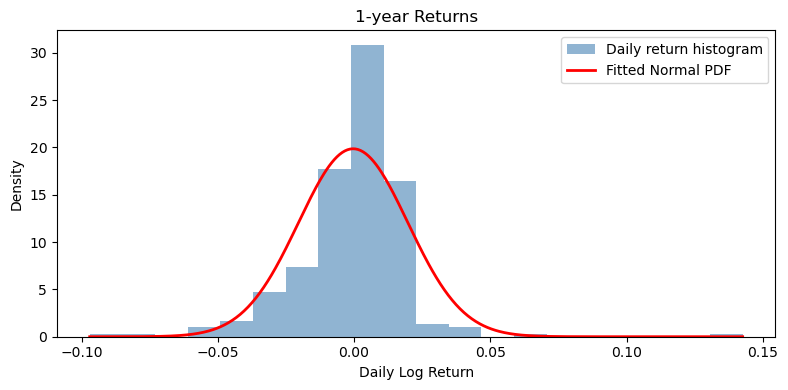

In [72]:
one_year_returns = data_1y['daily_return'].dropna().values

# 1-year return
r_mean = np.mean(one_year_returns)
r_std = np.std(one_year_returns)

## Property 1: Normally distributed increments
# Normalize histogram
plt.figure(figsize=(8, 4))
plt.hist(one_year_returns, bins=20, density=True, alpha=0.6, color='steelblue', label='Daily return histogram')

# Standard normal PDF
x = np.linspace(one_year_returns.min(), one_year_returns.max(), 500)
plt.plot(x, norm.pdf(x, r_mean, r_std), 'r-', lw=2, label='Fitted Normal PDF')

plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.title('1-year Returns')
plt.tight_layout()
plt.show()


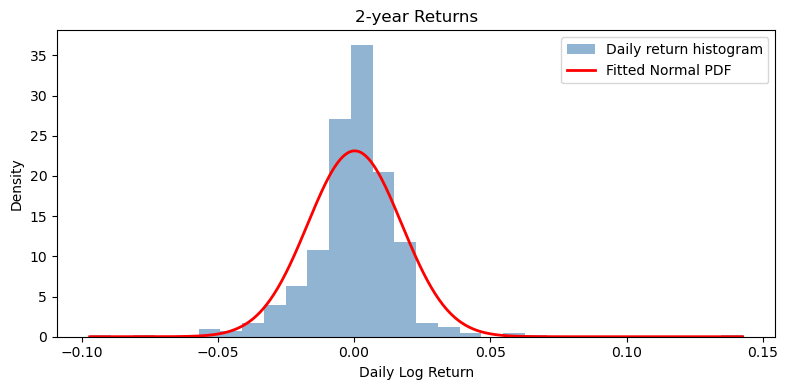

In [73]:
# 2-year return
two_year_returns = data_2y['daily_return'].dropna().values
r_mean = np.mean(two_year_returns)
r_std = np.std(two_year_returns)

## Property 1: Normally distributed increments
# Normalize histogram
plt.figure(figsize=(8, 4))
plt.hist(two_year_returns, bins=30, density=True, alpha=0.6, color='steelblue', label='Daily return histogram')

# Standard normal PDF
x = np.linspace(two_year_returns.min(), two_year_returns.max(), 500)
plt.plot(x, norm.pdf(x, r_mean, r_std), 'r-', lw=2, label='Fitted Normal PDF')

plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.title('2-year Returns')
plt.tight_layout()
plt.show()

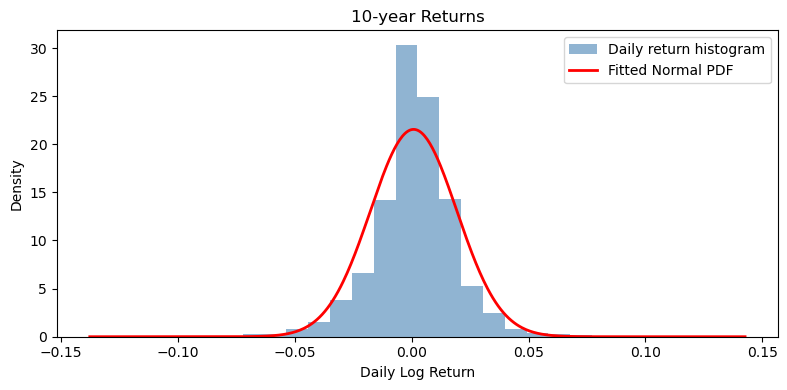

In [74]:
# 10-year return
ten_year_returns = data_10y['daily_return'].dropna().values
r_mean = np.mean(ten_year_returns)
r_std = np.std(ten_year_returns)

## Property 1: Normally distributed increments
# Normalize histogram
plt.figure(figsize=(8, 4))
plt.hist(ten_year_returns, bins=30, density=True, alpha=0.6, color='steelblue', label='Daily return histogram')

# Standard normal PDF
x = np.linspace(ten_year_returns.min(), ten_year_returns.max(), 500)
plt.plot(x, norm.pdf(x, r_mean, r_std), 'r-', lw=2, label='Fitted Normal PDF')

plt.xlabel('Daily Log Return')
plt.ylabel('Density')
plt.legend()
plt.title('10-year Returns')
plt.tight_layout()
plt.show()

### b) Statistical Tests

In [75]:
# Test for normality of returns using Shapiro-Wilk test
from scipy.stats import shapiro

stat, p = shapiro(data_1y['daily_return'].dropna().sample(min(5000, len(data_1y['daily_return'].dropna()))))

alpha = 0.05
if p > alpha:
	print('The data is normally distributed (not enough evidence to say data is normal)')
else:
	print('The data is not normally distributed (reject H0)')

The data is not normally distributed (reject H0)


In [76]:
# two-year returns
stat, p = st.shapiro(two_year_returns)
print(f"Statistics = {stat:.3f}, p = {p:.3f}")

alpha = 0.05
if p > alpha:
	print('The data is normally distributed (not enough evidence to say data is normal)')
else:
	print('The data is not normally distributed (reject H0)')

Statistics = 0.887, p = 0.000
The data is not normally distributed (reject H0)


In [77]:
# ten-year returns
stat, p = st.shapiro(ten_year_returns)
print(f"Statistics = {stat:.3f}, p = {p:.3f}")

alpha = 0.05
if p > alpha:
	print('The data is normally distributed (not enough evidence to say data is normal)')
else:
	print('The data is not normally distributed (reject H0)')

Statistics = 0.933, p = 0.000
The data is not normally distributed (reject H0)


### c) Graphical Methods

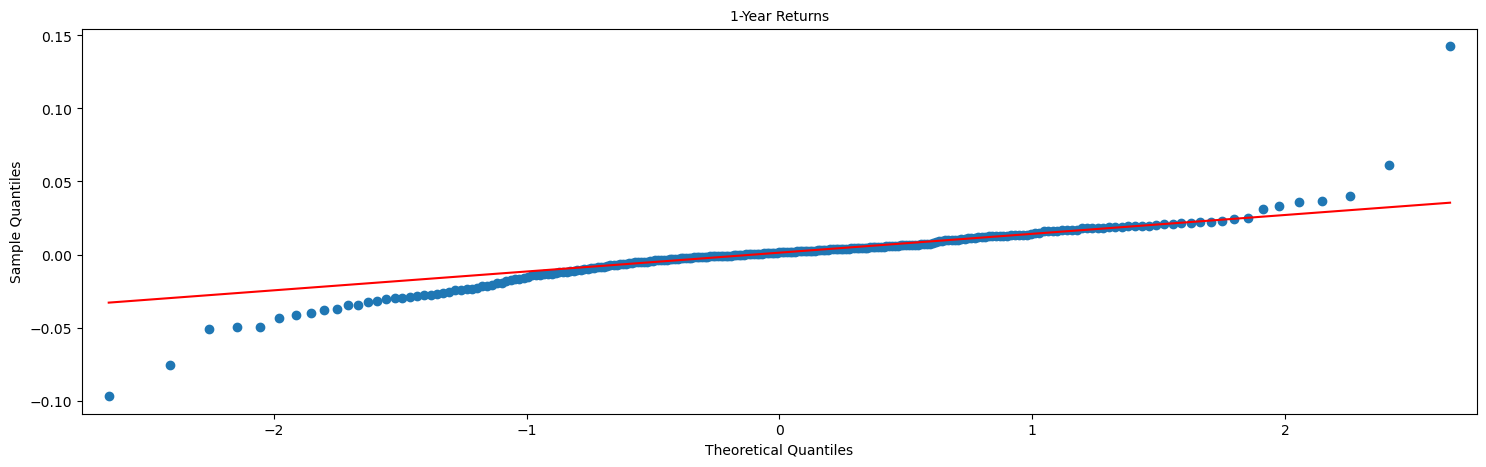

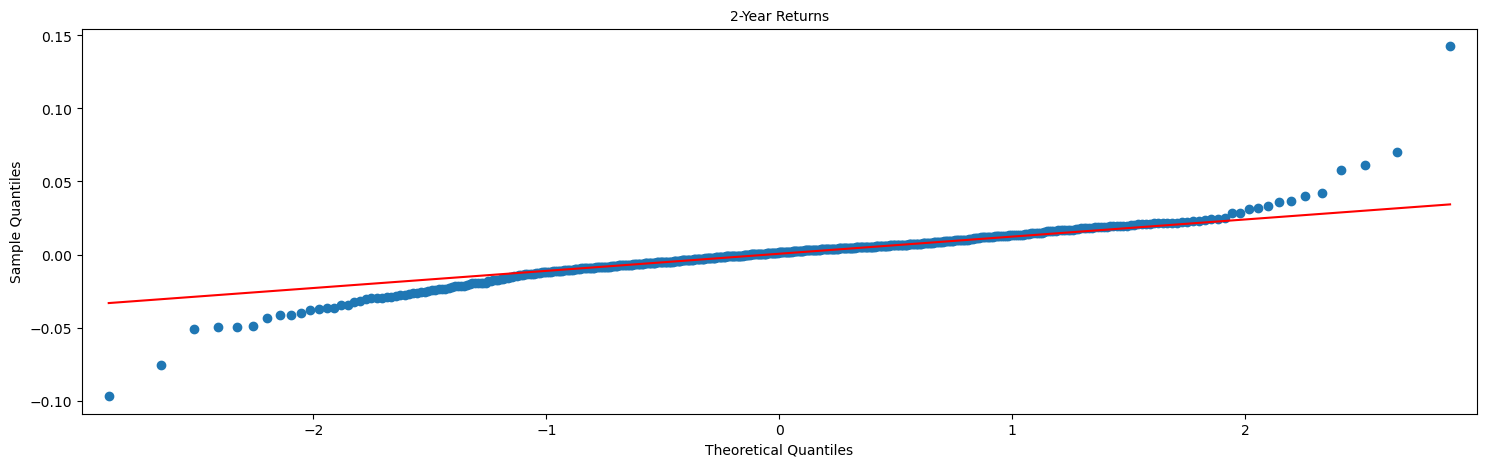

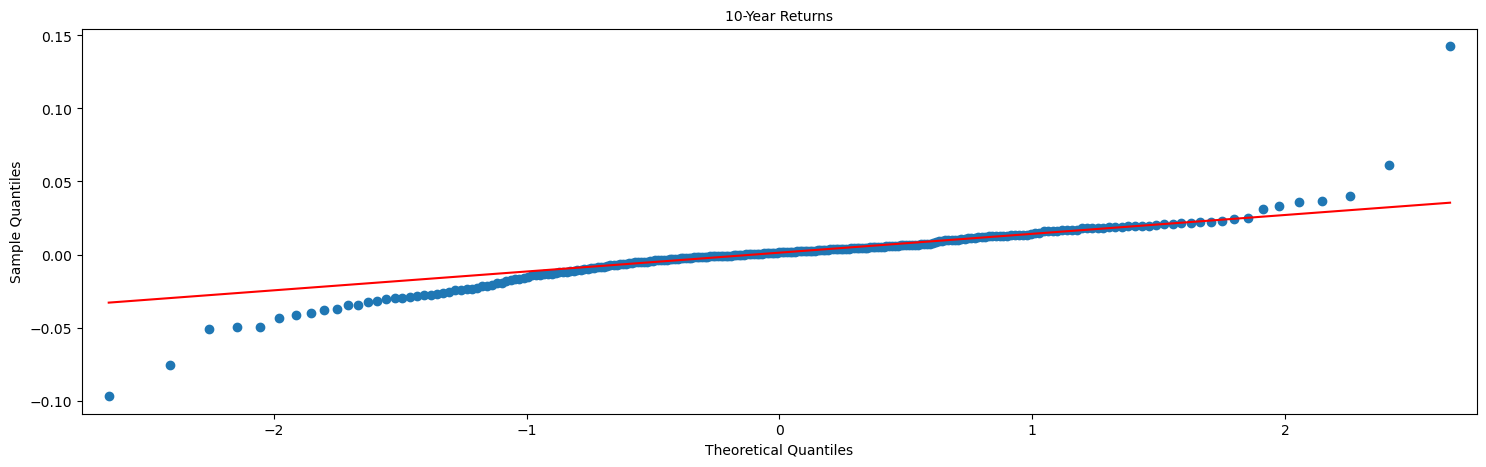

In [78]:
# 1-year-returns
figure = sm.qqplot(one_year_returns, line='q')
plt.title('1-Year Returns', fontsize = 10)
plt.show()

# 2-year-returns
figure = sm.qqplot(two_year_returns, line='q')
plt.title('2-Year Returns', fontsize = 10)
plt.show()

# 10-year-returns
figure = sm.qqplot(one_year_returns, line='q')
plt.title('10-Year Returns', fontsize = 10)
plt.show()

plt.rcParams["figure.figsize"] = (7,1)

* **Conclusion**: From the results obtained from the QQ-plot, they more supported the conclusion that all of the one-year, two-year and ten-year time-series data do not follow the normal (Gaussian) distribution.

## 2.2.3. Test for Independent increments

In [79]:
# 1-year returns
ljungbox_test = acorr_ljungbox(one_year_returns, lags=[10], return_df=True)
print(ljungbox_test)

      lb_stat  lb_pvalue
10  16.521769   0.085639


In [80]:
# 2-year returns
ljungbox_test = acorr_ljungbox(two_year_returns, lags=[10], return_df=True)
print(ljungbox_test)

      lb_stat  lb_pvalue
10  16.593007   0.083869


In [81]:
# 10-year returns
ljungbox_test = acorr_ljungbox(one_year_returns, lags=[10], return_df=True)
print(ljungbox_test)

      lb_stat  lb_pvalue
10  16.521769   0.085639


* **Conclusion**: The p-values of 1-year period, 2-year period and 10-year returns are all greater than $\alpha$ = 0.05. This implies that there are not enough evidence to reject the null hypothesis. Therefore, variables of those time-series of AAPL stock price are independent of each other.

## 2.2.4. Test for stationarity

### a) Plotting the time series data

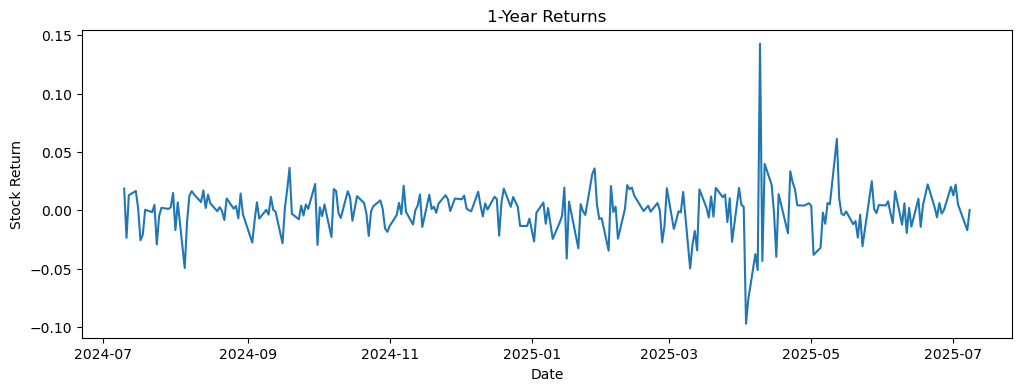

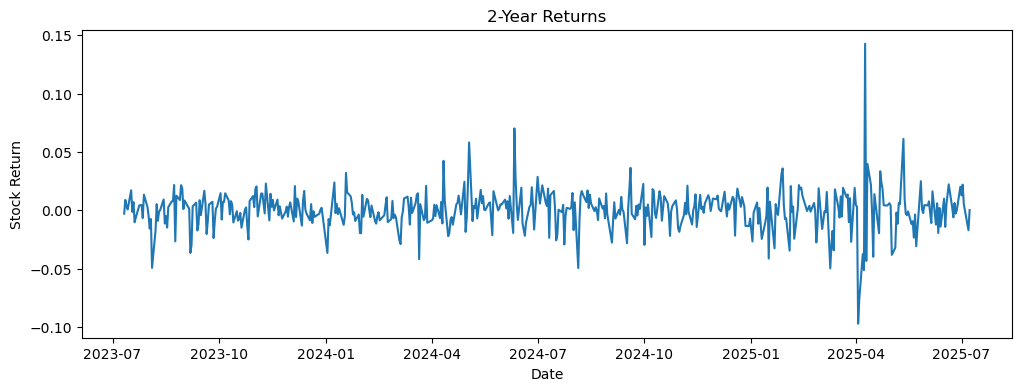

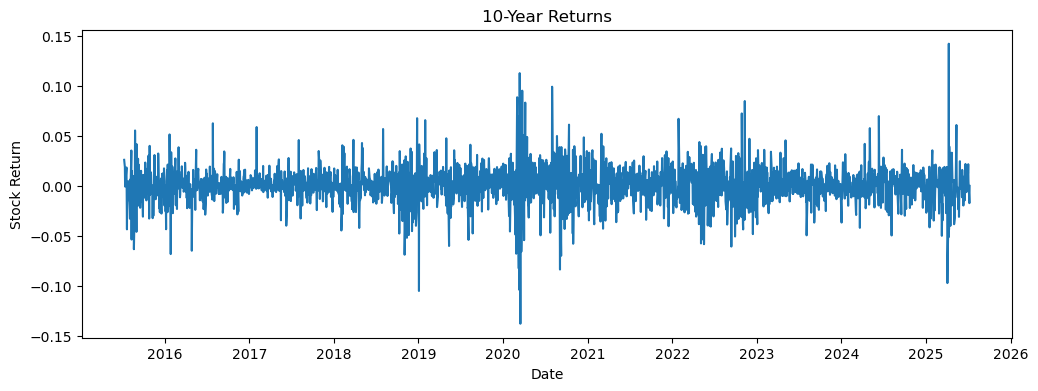

In [82]:
# Convert to DataFrames with proper column names
one_year_returns = data_1y['daily_return'].dropna()
two_year_returns = data_2y['daily_return'].dropna()
ten_year_returns = data_10y['daily_return'].dropna()

df1 = one_year_returns.reset_index()
df1.columns = ['Date', 'Daily Return']

df2 = two_year_returns.reset_index()
df2.columns = ['Date', 'Daily Return']

df3 = ten_year_returns.reset_index()
df3.columns = ['Date', 'Daily Return']

# Set figure size
plt.rcParams["figure.figsize"] = (12, 4)

# Plot 1-Year Returns
sns.lineplot(x='Date', y='Daily Return', data=df1).set(title='1-Year Returns', xlabel="Date", ylabel="Stock Return")
plt.show()

# Plot 2-Year Returns
sns.lineplot(x='Date', y='Daily Return', data=df2).set(title='2-Year Returns', xlabel="Date", ylabel="Stock Return")
plt.show()

# Plot 10-Year Returns
sns.lineplot(x='Date', y='Daily Return', data=df3).set(title='10-Year Returns', xlabel="Date", ylabel="Stock Return")
plt.show()


### b) Augmented Dickey-Fuller Test

In [83]:
# 1-year returns
ADF_test_result = adfuller(one_year_returns)
print(f'ADF Statistic: {ADF_test_result[0]}')
print(f'p-value: {ADF_test_result[1]}')

if ADF_test_result[1] < 0.05:
    print("The time-series is stationary (reject H0)")
else:
    print("The time-series is not stationary (not enough evidence to reject H0)")

ADF Statistic: -9.200020294599653
p-value: 2.013798014819605e-15
The time-series is stationary (reject H0)


In [84]:
# 2-year returns
ADF_test_result = adfuller(two_year_returns)
print(f'ADF Statistic: {ADF_test_result[0]}')
print(f'p-value: {ADF_test_result[1]}')

if ADF_test_result[1] < 0.05:
    print("The time-series is stationary (reject H0)")
else:
    print("The time-series is not stationary (not enough evidence to reject H0)")

ADF Statistic: -11.253961618886864
p-value: 1.68501425908783e-20
The time-series is stationary (reject H0)


In [85]:
# 10-year returns
ADF_test_result = adfuller(ten_year_returns)
print(f'ADF Statistic: {ADF_test_result[0]}')
print(f'p-value: {ADF_test_result[1]}')

if ADF_test_result[1] < 0.05:
    print("The time-series is stationary (reject H0)")
else:
    print("The time-series is not stationary (not enough evidence to reject H0)")

ADF Statistic: -15.933794251201638
p-value: 7.67646510938965e-29
The time-series is stationary (reject H0)


* **Conlcusion**: The p-values of 1-year period, 2-year period and 10-year returns are all smaller than $\alpha$ = 0.05. This implies that the time-series is stationary, meaning that the mean and variance of the dataset stay constant over time.

## 2.2.5. Contuinity test

### Plotting the historical stock prices

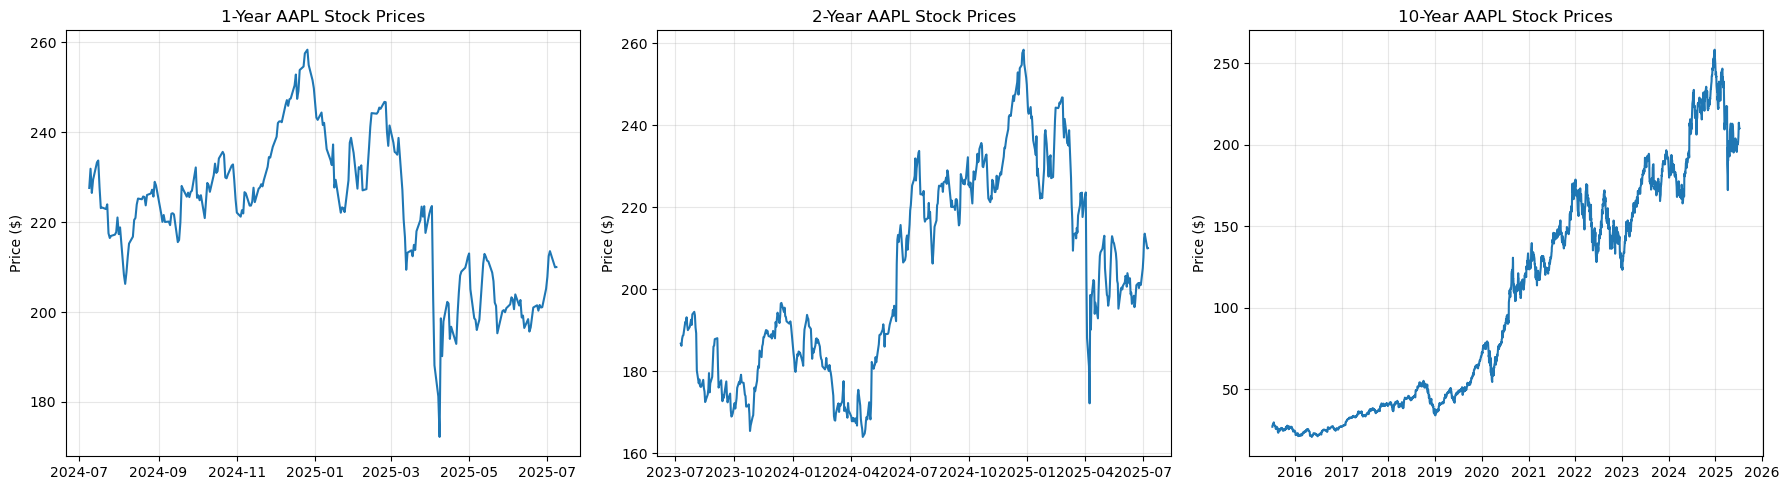

In [86]:
# Stock price plots for all timeframes
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1-year
axes[0].plot(data_1y.index, data_1y['Close'])
axes[0].set_title('1-Year AAPL Stock Prices')
axes[0].set_ylabel('Price ($)')
axes[0].grid(True, alpha=0.3)

# 2-year  
axes[1].plot(data_2y.index, data_2y['Close'])
axes[1].set_title('2-Year AAPL Stock Prices')
axes[1].set_ylabel('Price ($)')
axes[1].grid(True, alpha=0.3)

# 10-year
axes[2].plot(data_10y.index, data_10y['Close'])
axes[2].set_title('10-Year AAPL Stock Prices')
axes[2].set_ylabel('Price ($)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Generally, we observe that the log returns of the 1-year, 2-year and 10-year time series have continuity.

**Conclusion**: 
Although the 1-year, 2-year and 10-year time-series meet the properties of stationary, continuity and having simulated processes that start at zero at time zero, they do not exhibit normality. Therefore, we conclude that none of these time series follow gBM. However, for the purposes of the subsequent analysis, we still assume that they follow a gBM.





# 3. Long Straddle Strategy
In this section, we assume that 1-y, 2-y, and 10-y return series each follow a Geometric Brownian Motion for pricing.

**Outline:**

1. **Data Preparation** - Load stock data and extract current market conditions
2. **Strike Selection** - Select the optimal strike price using real market data
3. **Option Pricing** - Compare Black-Scholes theoretical vs. actual market premiums
4. **Payoff Construction** - Build profit/loss functions for the straddle strategy
5. **Overlay Visualization** - Create comprehensive comparison charts

## 3.1. Data Preparation and Market Context

Load the 10-year historical stock price data and extract the latest spot price. This forms the foundation for our analysis by establishing current market conditions and historical volatility patterns.

In [87]:
# ===== DATA PREPARATION =====

# Extract current market data for AAPL
current_stock_price = data_10y['Close'].iloc[-1]  # Latest closing price
data_date = data_10y.index[-1]
today = pd.Timestamp.now()

# Calculate data age
days_since_update = (today - data_date).days

# Calculate volatilities
vol_1yr = data_1y['daily_return'].dropna().std() * np.sqrt(252)
vol_2yr = data_2y['daily_return'].dropna().std() * np.sqrt(252)
vol_10yr = data_10y['daily_return'].dropna().std() * np.sqrt(252)

# Market parameters (realistic US market assumptions)
risk_free_rate = 0.045      # US 10-year Treasury rate approximation (4.5%)
dividend_yield = 0.005      # Approximate dividend yield for AAPL (~0.5%)

# Display current market context
print("MARKET OVERVIEW")
print(f"Ticker: {ticket} (Apple Inc.)")
print(f"Current Price: ${current_stock_price:.2f}")
print(f"Data Date: {data_date.strftime('%Y-%m-%d')} ({days_since_update} days ago)")

print()

print("VOLATILITY")
print(f"1-Year Vol:  {vol_1yr:.1%}")
print(f"2-Year Vol:  {vol_2yr:.1%}")  
print(f"10-Year Vol: {vol_10yr:.1%}")

print()

print("MARKET RATES")
print(f"Risk-free Rate: {risk_free_rate:.1%}")
print(f"Dividend Yield: {dividend_yield:.1%}")

MARKET OVERVIEW
Ticker: AAPL (Apple Inc.)
Current Price: $210.01
Data Date: 2025-07-08 (1 days ago)

VOLATILITY
1-Year Vol:  31.9%
2-Year Vol:  27.4%
10-Year Vol: 29.4%

MARKET RATES
Risk-free Rate: 4.5%
Dividend Yield: 0.5%


The 2-year historical volatility is chosen as the base because it offers a balanced view—it smooths out short-term noise seen in the 1-year vol but remains more relevant and timely than the longer-term 10-year vol. It reflects recent market conditions without overreacting to temporary spikes, making it a stable and realistic input for Black–Scholes pricing.

In [88]:
# Select base volatility
base_volatility = vol_2yr
print(f"Selected Base Volatility: {base_volatility:.1%} (2-year)")

Selected Base Volatility: 27.4% (2-year)


## 3.2. Strike Price Selection

Select the optimal strike price closest to the current spot price. For a long straddle, we typically use At-The-Money (ATM) strikes to maximize sensitivity to volatility while minimizing directional bias.

Real options trade only at listed strikes—often spaced by $2.50, $5, or $10 for a ticker like AAPL. We test common increments (2.5, 5, 10) and pick the strike with the smallest distance to spot

In [89]:
# ===== STRIKE PRICE SELECTION =====
increments = [5, 10, 2.5]  # Common option strike increments for AAPL

# Generate candidate strikes and pick the closest
candidates = [round(spot_price / inc) * inc for inc in increments]
K = min(candidates, key=lambda k: abs(k - spot_price))

# Output
print(f"Current AAPL Price: ${spot_price:.2f}")
print(f"Selected Strike K: ${K:.0f}")

Current AAPL Price: $210.01
Selected Strike K: $210


## 3.3. Option Pricing: Black-Scholes vs. Market Premiums

In this section, we perform option pricing for European call and put options on a dividend-paying stock using the Black-Scholes model. We assume that 1-y, 2-y, and 10-y return series each follow a Geometric Brownian Motion for pricing. That means the logarithm of returns is normally distributed. The pricing formulas are as follows:

The value of the call option is:

$$\begin{equation} c = S_0 e^{-qT} N(d_1) - K e^{-r T}N(d_2) \end{equation}$$

And the value of the put option is:

$$\begin{equation} p = K e^{-r T}N(-d_2) - S_0 e^{-qT} N(-d_1) \end{equation}$$

where:

$\begin{equation} d_1 = \frac{\ln(S_0 /K) + (r - q + \sigma^2 /2)T}{\sigma\sqrt{T}}  \end{equation}$<br>
$\begin{equation} d_2 = d_1 - \sigma\sqrt{T} \end{equation}$<br>
$S_0$ is the current stock price<br>
$K$ is the strike price<br>
$N(x)$ is the cumulative normal distribution<br>
$r$ is the risk-free rate<br>
$q$ is the dividend yield<br>
$T$ is the time to maturity<br>
$\sigma$ is the volatility of the stock price<br>

Based on the calculated option values, we implement a Long Straddle strategy on the underlying asset.

A **long straddle** buys a call and put at-the-money with the same maturity T at the same strike price K:

- **Call profit**: $$\pi_C = \text{Call Profit} \;= \max\bigl(S_T - K,\;0\bigr) - c $$
- **Put profit**: $$\pi_P = \text{Put Profit} \;= \max\bigl(S_T - K,\;0\bigr) - p $$
- **Total profit**: $$ \pi = \pi_C + \pi_P $$

We calculate theoretical option prices using the Black-Scholes model and compare them with actual market premiums. This comparison reveals market pricing efficiency.

### 3.3.1 Define Black–Scholes Pricing Function

We start by defining `bs_option_price()`, which returns the fair price of a European call or put under Black–Scholes (including a dividend yield).

In [90]:
# ===== BLACK-SCHOLES PRICING FUNCTION =====

def bs_option_price(S, K, T, r, sigma, q=0, option_type="call"):
    """
    Black–Scholes price for a European call or put.
    
    S : spot price
    K : strike
    T : time to maturity (years)
    r : risk-free rate
    sigma: volatility
    q : dividend yield
    option_type: "call" or "put"
    """
    # Immediate payoff if expired
    if T <= 0:
        return max((S - K) if option_type == "call" else (K - S), 0)

    # d1, d2 terms
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * np.exp(-q*T) * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    else:
        return K * np.exp(-r*T) * norm.cdf(-d2) - S * np.exp(-q*T) * norm.cdf(-d1)

### 3.3.2. Compute Theoretical (BS) Premiums

Using today's inputs—spot, strike, time to expiry, rates, vol—we calculate the model's call and put prices.

In [91]:
# Define expiry dates (realistic option expiries)
today = pd.Timestamp.now()
expiry_dates = [
    pd.Timestamp('2025-09-19'),  # September expiry (~2.5 months)
    pd.Timestamp('2025-12-19'),  # December expiry (~5.5 months)
    pd.Timestamp('2026-03-20')   # March expiry (~8.5 months)
]

# Calculate times to expiry in years
times_to_expiry = [(exp_date - today).days / 365.25 for exp_date in expiry_dates]

print("EXPIRY:")
for i, (exp_date, T) in enumerate(zip(expiry_dates, times_to_expiry)):
    print(f"Expiry {i+1}: {exp_date.strftime('%Y-%m-%d')} (T = {T:.3f} years)")

EXPIRY:
Expiry 1: 2025-09-19 (T = 0.194 years)
Expiry 2: 2025-12-19 (T = 0.444 years)
Expiry 3: 2026-03-20 (T = 0.693 years)


In [92]:
# ===== CALCULATE THEORETICAL BLACK-SCHOLES PREMIUMS =====

bs_results = {}

print("BLACK-SCHOLES THEORETICAL PREMIUMS")

for i, (exp_date, T) in enumerate(zip(expiry_dates, times_to_expiry), 1):
    # Calculate BS call and put prices
    call_bs = bs_option_price(spot_price, K, T, risk_free_rate, base_volatility, dividend_yield, "call")
    put_bs = bs_option_price(spot_price, K, T, risk_free_rate, base_volatility, dividend_yield, "put")
    straddle_cost_bs = call_bs + put_bs
    
    bs_results[f'expiry_{i}'] = {
        'expiry_date': exp_date,
        'time_to_expiry': T,
        'call_bs': call_bs,
        'put_bs': put_bs,
        'straddle_cost_bs': straddle_cost_bs
    }
    
    print(f"Expiry {i}: ${straddle_cost_bs:.2f} (Call ${call_bs:.2f} + Put ${put_bs:.2f})")

BLACK-SCHOLES THEORETICAL PREMIUMS
Expiry 1: $20.18 (Call $10.91 + Put $9.27)
Expiry 2: $30.36 (Call $17.03 + Put $13.33)
Expiry 3: $37.77 (Call $21.75 + Put $16.02)


### 3.3.3. Helper Functions for Profit & Breakevens

Define the core routines for computing straddle payoff and locating breakevens.

We need two utilities:
- **Profit calculator**: maps an array of expiry prices to P/L figures for call, put, and combined.
- **Breakeven finder**: scans the net P/L curve to locate where it crosses zero.

In [93]:
import numpy as np


def calculate_straddle_payoff(S_T, K, call_premium, put_premium):
    """Return call, put, and net P/L arrays for a straddle at expiry prices S_T."""
    call_profit = np.maximum(S_T - K, 0) - call_premium
    put_profit = np.maximum(K - S_T, 0) - put_premium
    return {
        'call_profit': call_profit,
        'put_profit':  put_profit,
        'net_pl':      call_profit + put_profit
    }


def find_breakeven_points(S_T, net_pl):
    """Find the two prices where net P/L crosses zero (breakevens)."""
    bes = []
    for i in range(len(net_pl) - 1):
        if net_pl[i] * net_pl[i+1] < 0:
            # linear interpolate zero-crossing
            frac = -net_pl[i] / (net_pl[i+1] - net_pl[i])
            bes.append(S_T[i] + frac * (S_T[i+1] - S_T[i]))
    return bes

## 3.3. Fetch Real Market Option Data

Use `yfinance` to load the option chains for the target expiries and strike.

In [94]:
ticker = yf.Ticker(ticket)
all_expiries = ticker.options

# Map your desired dates (expiry_dates list of Timestamps) to actual listings
target_expiries = [
    min(all_expiries, key=lambda d: abs((pd.to_datetime(d) - td).days))
    for td in expiry_dates
]

market_results = {}

print("Fetching real-market premiums:")
for i, exp in enumerate(target_expiries, 1):
    calls, puts = ticker.option_chain(exp).calls, ticker.option_chain(exp).puts

    # pick the strike nearest to your K
    call_row = calls.loc[(calls['strike'] - K).abs().idxmin()]
    put_row = puts.loc[(puts['strike'] - K).abs().idxmin()]

    # extract last-trade prices
    c_mkt = call_row['lastPrice']
    p_mkt = put_row['lastPrice']

    # compute time to expiry in years
    T = (pd.to_datetime(exp) - today).days / 365.25

    # compute BS theoretical prices for comparison
    c_bs = bs_option_price(current_stock_price, call_row['strike'], T,
                           risk_free_rate, base_volatility, dividend_yield, "call")
    p_bs = bs_option_price(current_stock_price, put_row['strike'],  T,
                           risk_free_rate, base_volatility, dividend_yield, "put")

    market_results[f'expiry_{i}'] = {
        'expiry_date':   pd.to_datetime(exp),
        'time_to_expiry': T,
        'call_market':   c_mkt,
        'put_market':    p_mkt,
        'call_bs':       c_bs,
        'put_bs':        p_bs,
        'strike':        call_row['strike']
    }

    print(f"Expiry {i}: Market={c_mkt+p_mkt:.2f} vs BS={c_bs+p_bs:.2f}")

Fetching real-market premiums:
Expiry 1: Market=20.34 vs BS=20.18
Expiry 2: Market=30.65 vs BS=30.36
Expiry 3: Market=38.90 vs BS=37.77


## 3.4 Prepare P/L Analysis

Build a grid of possible expiry prices, compute P/L for both market and theoretical premiums, 
find breakevens and max loss, and store in `pl_results`.

In [95]:
print("Calculating P/L profiles for each expiry")

pct = 0.30
Smin = current_stock_price * (1-pct)
Smax = current_stock_price * (1+pct)
S_T = np.linspace(Smin, Smax, 100)

pl_results = {}

for key, data in market_results.items():
    # P/L curves
    bs_pl = calculate_straddle_payoff(S_T, data['strike'],
                                      data['call_bs'], data['put_bs'])
    mkt_pl = calculate_straddle_payoff(S_T, data['strike'],
                                       data['call_market'], data['put_market'])
    # breakevens
    be_bs = find_breakeven_points(S_T, bs_pl['net_pl'])
    be_mkt = find_breakeven_points(S_T, mkt_pl['net_pl'])

    pl_results[key] = {
        'expiry_date':       data['expiry_date'],
        'time_to_expiry':    data['time_to_expiry'],
        'S_T':               S_T,
        'pl_bs':             bs_pl,
        'pl_market':         mkt_pl,
        'breakevens_bs':     be_bs,
        'breakevens_market': be_mkt,
        'max_loss_bs': -(data['call_bs'] + data['put_bs']),
        'max_loss_market': -(data['call_market'] + data['put_market'])
    }

    be_str = f"{be_mkt[0]:.0f}–{be_mkt[1]:.0f}" if len(be_mkt) == 2 else "N/A"
    mloss = pl_results[key]['max_loss_market']
    print(f"{key}: Max loss {mloss:.2f}, Breakevens {be_str}")

Calculating P/L profiles for each expiry
expiry_1: Max loss -20.34, Breakevens 190–230
expiry_2: Max loss -30.65, Breakevens 179–241
expiry_3: Max loss -38.90, Breakevens 171–249


## 3.5 Overlay Visualization: Black-Scholes vs. Market P/L

Create comprehensive comparison charts showing theoretical vs. actual P/L curves for each maturity. This visualization directly addresses the core task of overlaying Black-Scholes and market-based profit/loss functions.

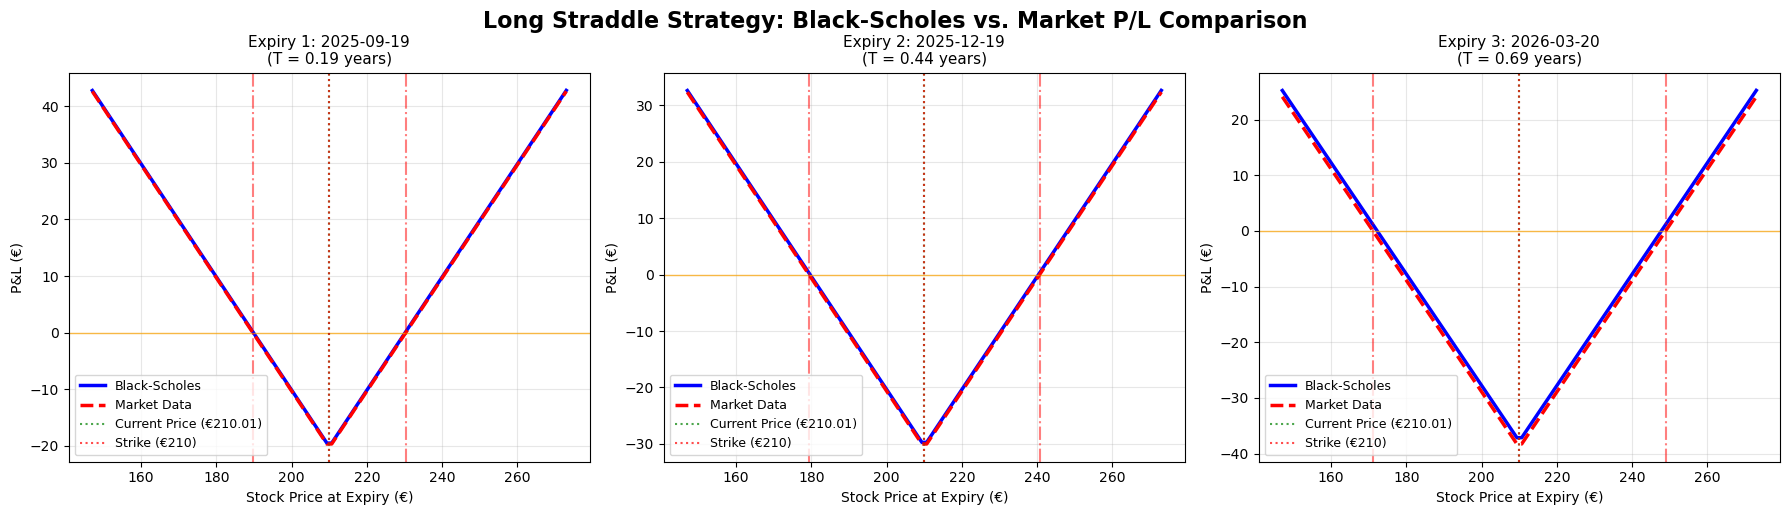

In [96]:
# ===== P/L COMPARISON: BLACK-SCHOLES vs MARKET =====
plt.rcParams["figure.figsize"] = (18, 5)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colors
color_bs, color_market, color_zero = 'blue', 'red', 'orange'

for i, (key, data) in enumerate(pl_results.items()):
    ax = axes[i]
    
    # Plot P/L curves
    ax.plot(data['S_T'], data['pl_bs']['net_pl'],
            linewidth=2.5, label='Black-Scholes', color=color_bs)
    ax.plot(data['S_T'], data['pl_market']['net_pl'], 
            linewidth=2.5, label='Market Data', color=color_market, linestyle='--')
    
    # Reference lines
    ax.axhline(y=0, color=color_zero, linestyle='-', alpha=0.7, linewidth=1)
    ax.axvline(x=spot_price, color='green', linestyle=':', alpha=0.7, label=f'Current Price (€{spot_price:.2f})')
    ax.axvline(x=K, color='red', linestyle=':', alpha=0.7, label=f'Strike (€{K:.0f})')
    
    # Breakeven points
    if data['breakevens_market']:
        for be in data['breakevens_market']:
            ax.axvline(x=be, color=color_market, linestyle='-.', alpha=0.5)
    
    # Formatting
    expiry_str = data['expiry_date'].strftime('%Y-%m-%d')
    ax.set_title(f"Expiry {i+1}: {expiry_str}\n(T = {data['time_to_expiry']:.2f} years)", fontsize=11)
    ax.set_xlabel('Stock Price at Expiry (€)')
    ax.set_ylabel('P&L (€)')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

plt.tight_layout()
plt.suptitle('Long Straddle Strategy: Black-Scholes vs. Market P/L Comparison', 
             fontsize=16, fontweight='bold', y=1.02)
plt.show()

## 3.6. Key Findings from Black-Scholes vs. Market P/L Comparison

**Strong Model Alignment**: The Black-Scholes and market-based P/L curves show remarkably similar patterns across all three expiries, indicating that the theoretical model captures the fundamental payoff structure well.

**Strategic Conclusion**: The close alignment validates using Black-Scholes for initial strategy analysis, while market data provides the precision needed for actual trade execution. This dual approach ensures both theoretical soundness and practical applicability.

# References

[1] Black, F., & Scholes, M. (1973). The pricing of options and corporate liabilities. *Journal of Political Economy*, 81(3), 637-654.

[2] Dare, J., Patrick, A. O., & Oyewola, D. O. (2022). Comparison of stationarity on Ljung box test statistics for forecasting. *Earthline Journal of Mathematical Sciences*, 8(2), 325-336.

[3] Gaigall, D., & Wübbolding, P. (2025). A goodness-of-fit test for geometric Brownian motion. *Computational Statistics & Data Analysis*, 108196.

[4] Henze, N. (2024). Wiener Process, Donsker's Theorem, and Brownian Bridge. *In Asymptotic Stochastics: An Introduction with a View towards Statistics* (pp. 271-305). Berlin, Heidelberg: Springer Berlin Heidelberg.

[5] Hull, J. C. (2017). Options, futures, and other derivatives. *Pearson Education Limited*.

[6] Mahan, M. Y., Chorn, C. R., & Georgopoulos, A. P. (2015, July). White Noise Test: detecting autocorrelation and nonstationarities in long time series after ARIMA modeling. *In SciPy* (pp. 97-104).

[7] Shapiro, S.S., Wilk, M.B., 1965. An analysis of variance test for normality (Complete Samples). *Biometrika 52*, 591–611

[8] Steland, A. (2007). Weighted Dickey–Fuller processes for detecting stationarity. *Journal of Statistical Planning and Inference*, 137(12), 4011-4030.

[9] Wilmott, P. (2006). Paul Wilmott introduces quantitative finance. *John Wiley & Sons*.

